## Курсовая работа по курсу "Математическое моделирование и вычислительный эксперимент"
#### Выполнил: Стрыгин Д.Д.
#### Группа: М8О-406Б-19

In [ ]:
import numpy as np
import pylab
import math
from tqdm import tqdm

In [ ]:
def to_phi(nrho, nu, nv, neps, k, i, j):
    rho, u, v, eps = nrho[k, i, j], nu[k, i, j], nv[k, i, j], neps[k, i, j]
    return np.array([rho, rho * u, rho * v, rho * (eps + 0.5 * (u * u + v * v))])

def from_phi(phi):
    rho = phi[0]
    u = phi[1] / rho
    v = phi[2] / rho
    eps = phi[3] / rho - 0.5 * (u * u + v * v)
    return rho, u, v, eps

def get_Fx(gamma, phi):
    rho, u, v, eps = from_phi(phi)
    P = (gamma - 1) * rho * eps
    E = rho * (eps + 0.5 * (u * u + v * v))
    return np.array([ rho * u, rho * u * u + P, rho * u * v, (E + P) * u ])

def get_Fy(gamma, phi):
    rho, u, v, eps = from_phi(phi)
    P = (gamma - 1) * rho * eps
    E = rho * (eps + 0.5 * (u * u + v * v))
    return np.array([ rho * v, rho * u * v, rho * v * v + P, (E + P) * v ])

In [ ]:
def get_F_half(phi_m1, phi_p1, phi_m, phi_p, gamma, vert):
    rho_m1, u_m1, v_m1, eps_m1 = from_phi(phi_m1)
    rho_p1, u_p1, v_p1, eps_p1 = from_phi(phi_p1)
    rho_m, u_m, v_m, eps_m = from_phi(phi_m)
    rho_p, u_p, v_p, eps_p = from_phi(phi_p)

    s_m1 = v_m1 if vert else u_m1
    s_p1 = v_p1 if vert else u_p1
    s_m = v_m if vert else u_m
    s_p = v_p if vert else u_p

    c_m1 = math.sqrt(gamma * (gamma - 1) * eps_m1)
    c_p1 = math.sqrt(gamma * (gamma - 1) * eps_p1)
    c_m = math.sqrt(gamma * (gamma - 1) * eps_m)
    c_p = math.sqrt(gamma * (gamma - 1) * eps_p)

    c_mh = max(c_m1 + abs(s_m1), c_m + abs(s_m))
    c_ph = max(c_p1 + abs(s_p1), c_p + abs(s_p))

    get_F = get_Fy if vert else get_Fx

    F_m1 = get_F(gamma, phi_m1)
    F_p1 = get_F(gamma, phi_p1)
    F_m = get_F(gamma, phi_m)
    F_p = get_F(gamma, phi_p)

    F_mh = 0.5 * (F_m1 + F_m - c_mh * (phi_m1 - phi_m))
    F_ph = 0.5 * (F_p + F_p1 - c_ph * (phi_p - phi_p1))
    return F_mh, F_ph

In [ ]:
def border2(phi_m, phi, phi_p, phi_2p):
    aRm = alpha_all(phi - phi_m, phi_p - phi)
    aRp = alpha_all(phi_p - phi, phi_2p - phi_p)

    phi_hm = phi + 0.5 * aRm * (phi_p - phi)
    phi_hp = phi_p - 0.5 * aRp * (phi_2p - phi_p)
    return phi_hm, phi_hp

def alpha_all(R1, R2):
    R = np.zeros_like(R1)
    for i in range(R.shape[0]):
        if R2[i] != 0:
            R[i] = R1[i] / R2[i]
            if R[i] < 0: R[i] = 0
            elif R[i] > 1: R[i] = 1
    return R

In [ ]:
def solve(orderXY, orderT,n, Nx, Ny, Nt, T, M, gamma, alpha, rho_0, eps_0, u_0, v_0):
    rho = np.zeros(shape=(Nt + orderT - 1, Nx + 4, Ny + 4))
    u = np.zeros(shape=(Nt + orderT - 1, Nx + 4, Ny + 4))
    v = np.zeros(shape=(Nt + orderT - 1, Nx + 4, Ny + 4))
    eps = np.zeros(shape=(Nt + orderT - 1, Nx + 4, Ny + 4))

    dx, dy, dt = 1.0 / Nx, 1.0 / Ny, T / Nt

    rho1 = rho_0[0]
    rho2 = rho_0[1]
    rho3 = rho_0[2]
    rho4 = rho_0[3]

    eps1 = eps_0[0]
    eps2 = eps_0[1]
    eps3 = eps_0[2]
    eps4 = eps_0[3]

    u1 = u_0[0]
    u2 = u_0[1]
    u3 = u_0[2]
    u4 = u_0[3]

    v1 = v_0[0]
    v2 = v_0[1]
    v3 = v_0[2]
    v4 = v_0[3]

    for i in range(2, Nx + 2):
        for j in range(2, Ny + 2):
            x, y = (i - 2 + 0.5) * dx, (j - 2 + 0.5) * dy

            if(i <= (Nx + 2)/2):
                if(j <= (Ny + 2)/2):
                    rho[0,i,j] = rho1
                    eps[0,i,j] = eps1
                    u[0,i,j] = u1
                    v[0,i,j] = v1
                else:
                    rho[0,i,j] = rho2
                    eps[0,i,j] = eps2
                    u[0,i,j] = u2
                    v[0,i,j] = v2
            else:
                if(j <= (Ny + 2)/2):
                    rho[0,i,j] = rho3
                    eps[0,i,j] = eps3
                    u[0,i,j] = u3
                    v[0,i,j] = v3
                else:
                    rho[0,i,j] = rho4
                    eps[0,i,j] = eps4
                    u[0,i,j] = u4
                    v[0,i,j] = v4

    k0, k = -1, orderT - 2
    for repeat in tqdm(range(0, orderT * (Nt - 1))):

        if orderT == 1:
            k0 += 1
            k += 1
        elif k0 == k:
            k = -1
        else:
            k0 += 1
            k = k0

        for j in range(2, Ny + 2):
            for i in range(2):
                rho[k, i, j] = rho[k, 3 - i, j]
                u[k, i, j] = -u[k, 3 - i, j]
                v[k, i, j] = v[k, 3 - i, j]
                eps[k, i, j] = eps[k, 3 - i, j]
                rho[k, Nx + 2 + i, j] = rho[k, Nx + 1 - i, j]
                u[k, Nx + 2 + i, j] = -u[k, Nx + 1 - i, j]
                v[k, Nx + 2 + i, j] = v[k, Nx + 1 - i, j]
                eps[k, Nx + 2 + i, j] = eps[k, Nx + 1 - i, j]

        for i in range(2, Nx + 2):
            for j in range(2):
                rho[k, i, j] = rho[k, i, 3 - j]
                u[k, i, j] = u[k, i, 3 - j]
                v[k, i, j] = -v[k, i, 3 - j]
                eps[k, i, j] = eps[k, i, 3 - j]
                rho[k, i, Ny + 2 + j] = rho[k, i, Ny + 1 - j]
                u[k, i, Ny + 2 + j] = u[k, i, Ny + 1 - j]
                v[k, i, Ny + 2 + j] = -v[k, i, Ny + 1 - j]
                eps[k, i, Ny + 2 + j] = eps[k, i, Ny + 1 - j]

        for i in range(2, Nx + 2):
            for j in range(2, Ny + 2):
                phi1 = to_phi(rho, u, v, eps, k0, i, j)

                phi = to_phi(rho, u, v, eps, k, i, j)
                phi_mx = to_phi(rho, u, v, eps, k, i - 1, j)
                phi_px = to_phi(rho, u, v, eps, k, i + 1, j)
                phi_my = to_phi(rho, u, v, eps, k, i, j - 1)
                phi_py = to_phi(rho, u, v, eps, k, i, j + 1)

                if orderXY == 2:
                    phi_2mx = to_phi(rho, u, v, eps, k, i - 2, j)
                    phi_2px = to_phi(rho, u, v, eps, k, i + 2, j)
                    phi_2my = to_phi(rho, u, v, eps, k, i, j - 2)
                    phi_2py = to_phi(rho, u, v, eps, k, i, j + 2)

                    phi_hmx_m, phi_hmx_p = border2(phi_2mx, phi_mx, phi, phi_px)
                    phi_hpx_m, phi_hpx_p = border2(phi_mx, phi, phi_px, phi_2px)
                    phi_hmy_m, phi_hmy_p = border2(phi_2my, phi_my, phi, phi_py)
                    phi_hpy_m, phi_hpy_p = border2(phi_my, phi, phi_py, phi_2py)

                    F_mhx, F_phx = get_F_half(phi_hmx_p, phi_hpx_m, phi_hmx_m, phi_hpx_p, gamma, False)
                    F_mhy, F_phy = get_F_half(phi_hmy_p, phi_hpy_m, phi_hmy_m, phi_hpy_p, gamma, True)
                else:
                    F_mhx, F_phx = get_F_half(phi, phi, phi_mx, phi_px, gamma, False)
                    F_mhy, F_phy = get_F_half(phi, phi, phi_my, phi_py, gamma, True)

                mult = 0.5 if k == k0 and orderT == 2 else 1
                phi2 = phi1 - mult * dt / dx * (F_phx - F_mhx) - mult * dt / dy * (F_phy - F_mhy)

                kw = -1 if k == k0 and orderT == 2 else k0 + 1
                rho[kw, i, j], u[kw, i, j], v[kw, i, j], eps[kw, i, j] = from_phi(phi2)

    return rho[:Nt, 2:Nx+2, 2:Ny+2], u[:Nt, 2:Nx+2, 2:Ny+2], v[:Nt, 2:Nx+2, 2:Ny+2], eps[:Nt, 2:Nx+2, 2:Ny+2]

In [ ]:
def plot(time_index):
    print('t =', time_index * T / Nt)

    pylab.figure()
    fig, splots = pylab.subplots(1, 4)
    fig.set_figheight(5)
    fig.set_figwidth(20)

    for i, arr in enumerate([np.log(rho), u, v, np.log(eps)]):
        splots[i].imshow(np.flip(arr[time_index].T, axis=0), cmap='binary')

    pylab.show()

In [ ]:
#Вариант 21
alpha = 0.05
n = 0.0625
M = 0.0625

Nx, Ny = 40, 40
Nt = 40
T = 0.1

rho_0 = [1,1,1,10]
esp_0 = [10,1,1,10]
u_0 = [0,0,0,0]
v_0 = [0,0,0,0]

t1, t2, t3 = 3, 15, 25

Зададим сетку размером 640х640

Запустим схему первого порядка точности по времени и пространству:

In [ ]:
gamma = 25/24
rho, u, v, eps = solve(orderXY = 1, orderT = 1, Nx = Nx, Ny = Ny, Nt = Nt, T = T, M = M, gamma = gamma,
                       alpha = alpha, n = n,
                       rho_0 = rho_0,
                       eps_0 = esp_0,
                       u_0 = u_0,
                       v_0 = v_0)

100%|██████████| 39/39 [00:03<00:00, 10.52it/s]


Построим графики для начального момента времени:

t = 0.0


<Figure size 640x480 with 0 Axes>

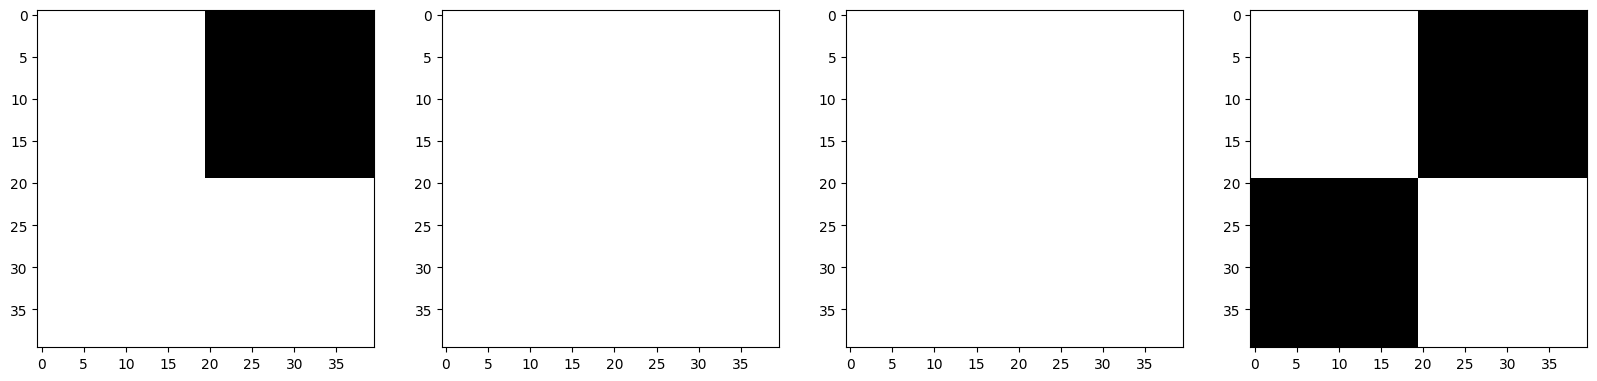

t = 0.0075000000000000015


<Figure size 640x480 with 0 Axes>

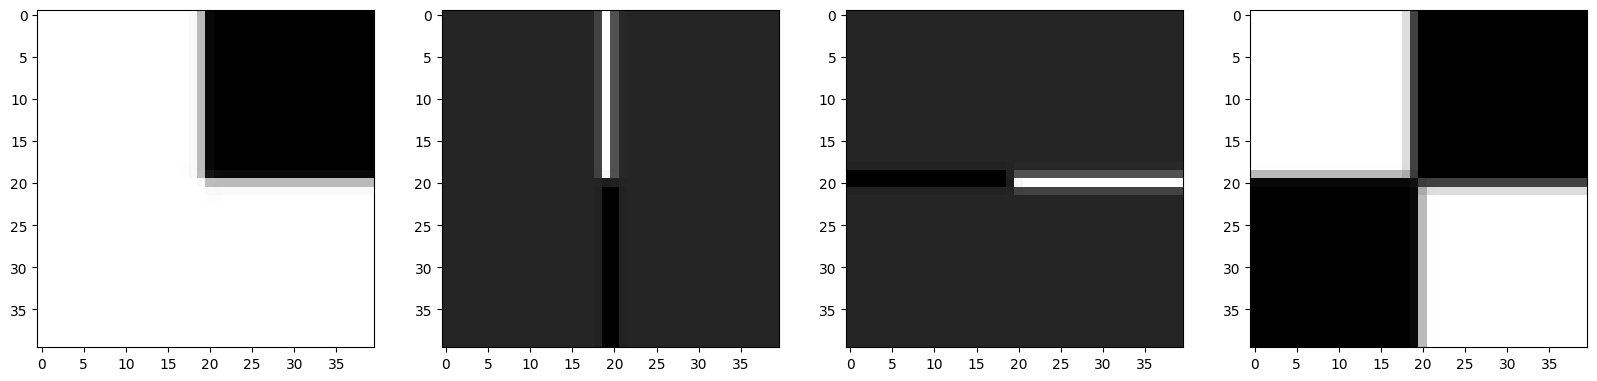

t = 0.0375


<Figure size 640x480 with 0 Axes>

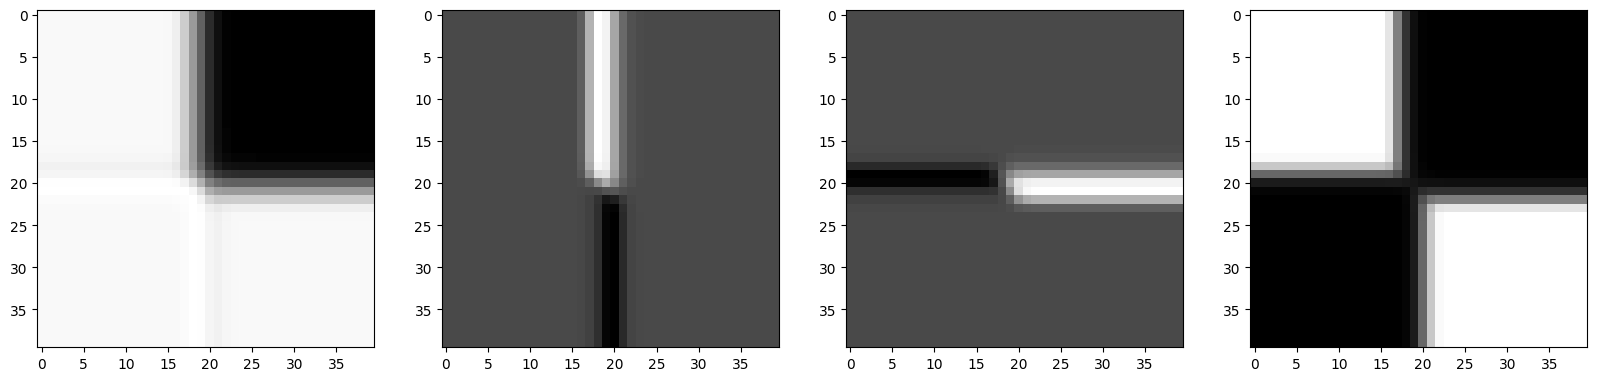

t = 0.0625


<Figure size 640x480 with 0 Axes>

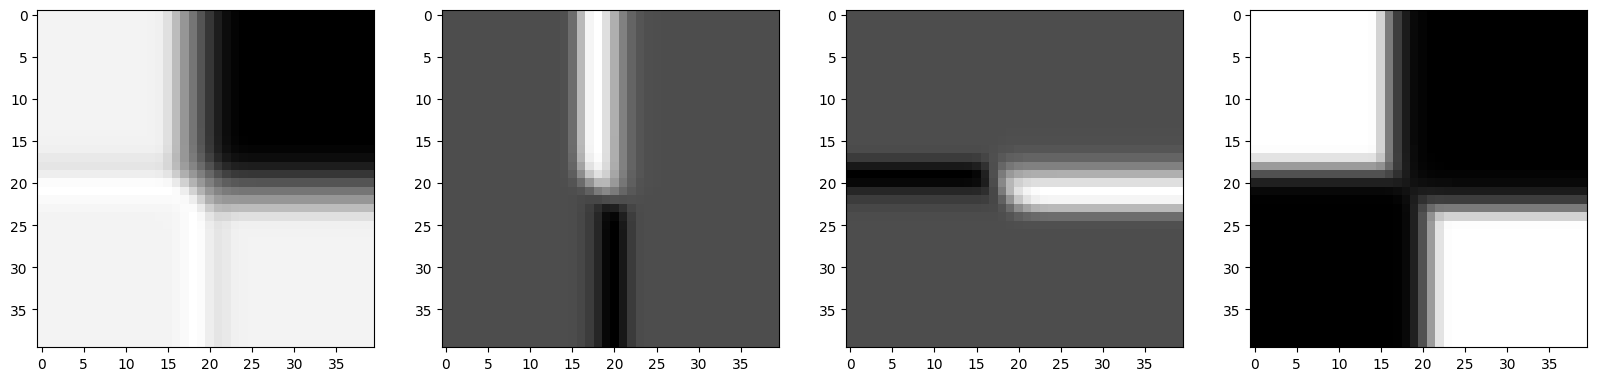

In [ ]:
plot(0)
plot(t1)
plot(t2)
plot(t3)

второй порядок по пространству, первый по времени

In [ ]:
gamma = 26/25
rho, u, v, eps = solve(orderXY = 2, orderT = 1, Nx = Nx, Ny = Ny, Nt = Nt, T = T, M = M, gamma = gamma,
                       alpha = alpha, n = n,
                       rho_0 = rho_0,
                       eps_0 = esp_0,
                       u_0 = u_0,
                       v_0 = v_0)

100%|██████████| 39/39 [00:11<00:00,  3.26it/s]


t = 0.0075000000000000015


<Figure size 640x480 with 0 Axes>

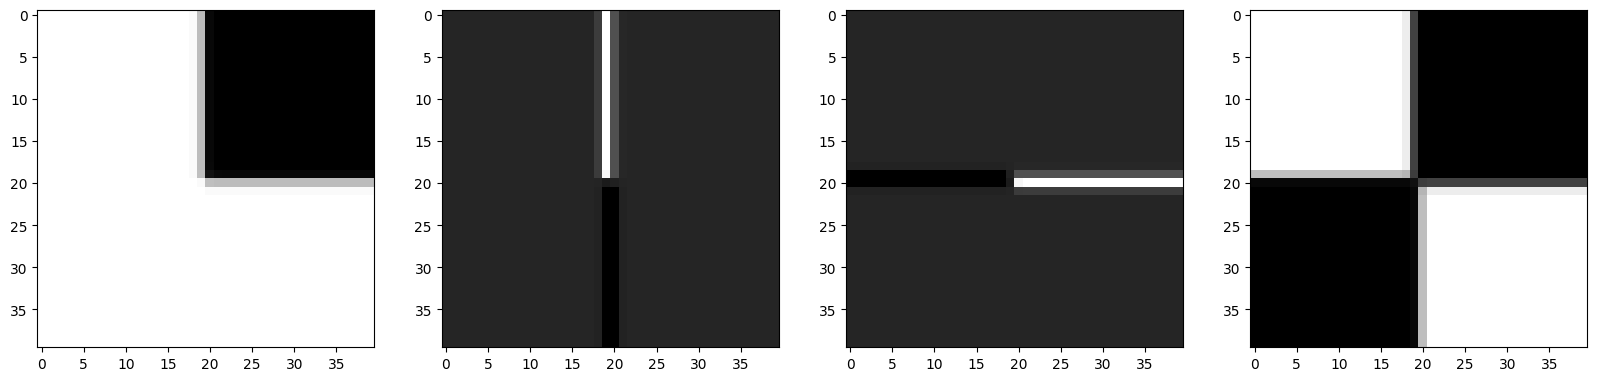

t = 0.0375


<Figure size 640x480 with 0 Axes>

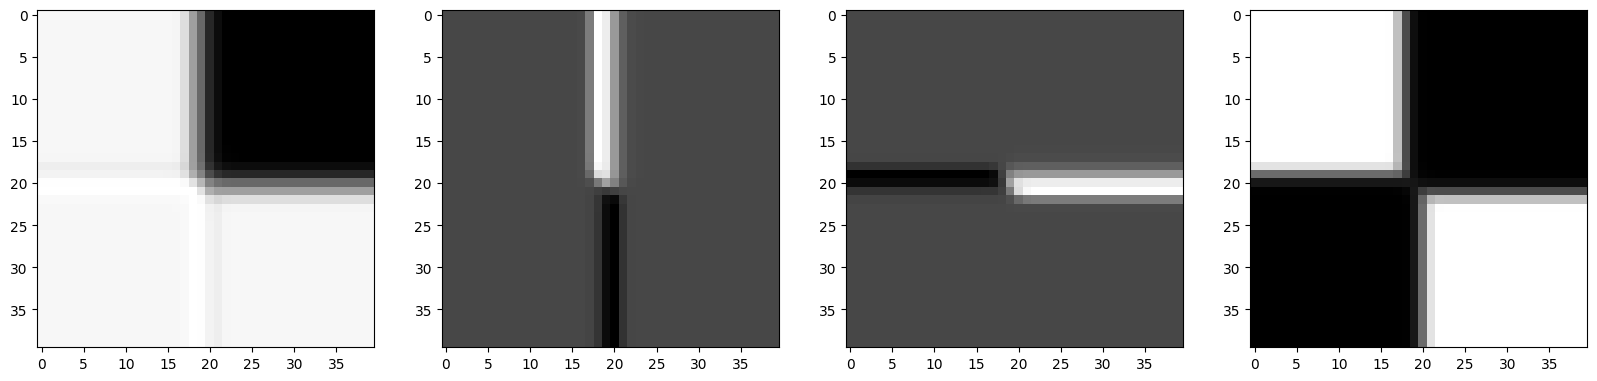

t = 0.0625


<Figure size 640x480 with 0 Axes>

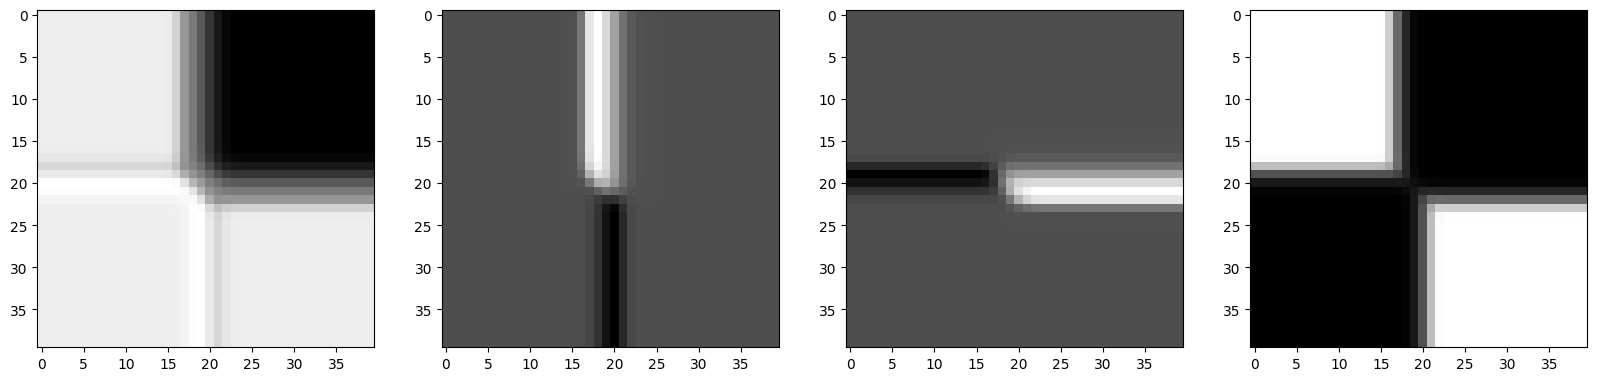

In [ ]:
plot(t1)
plot(t2)
plot(t3)

Второй порядок по пространству, второй по времени.

In [ ]:
gamma = 28/27
rho, u, v, eps = solve(orderXY = 2, orderT = 2, Nx = Nx, Ny = Ny, Nt = Nt, T = T, M = M, gamma = gamma,
                       alpha = alpha, n = n,
                       rho_0 = rho_0,
                       eps_0 = esp_0,
                       u_0 = u_0,
                       v_0 = v_0)

100%|██████████| 58/58 [00:16<00:00,  3.59it/s]


t = 0.04000000000000001


<Figure size 640x480 with 0 Axes>

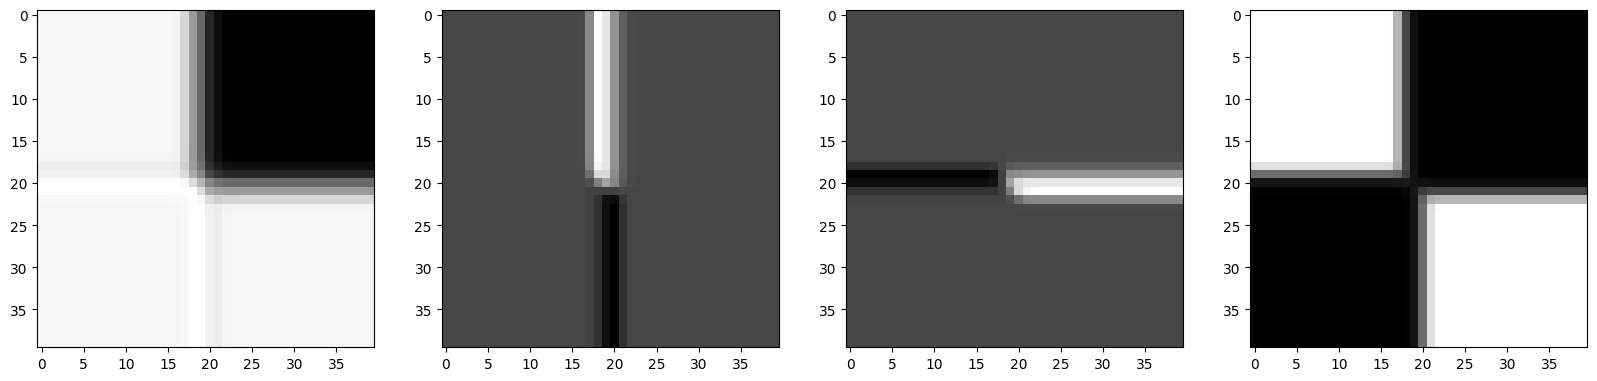

t = 0.2


<Figure size 640x480 with 0 Axes>

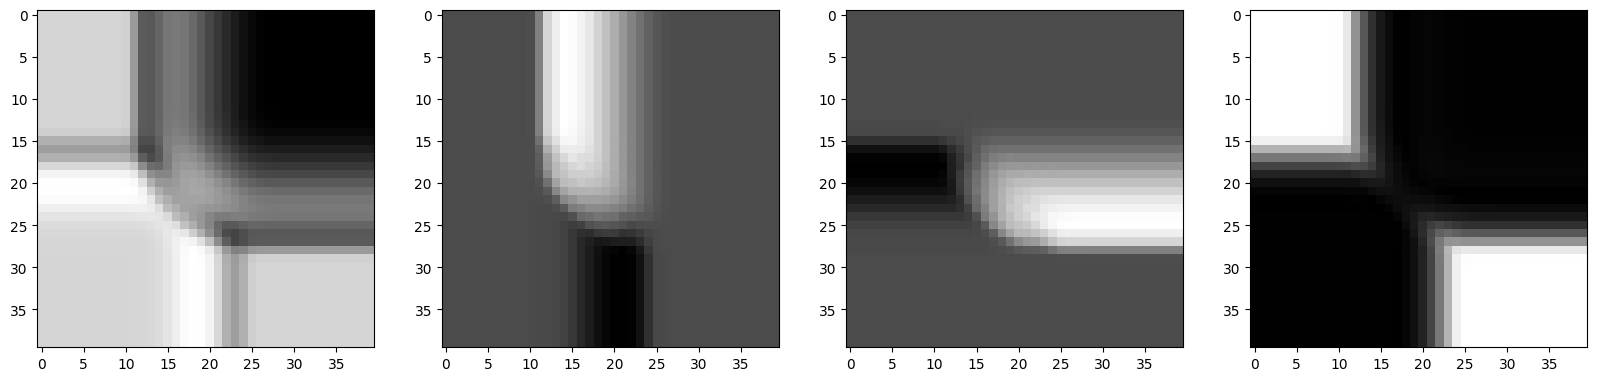

t = 0.3333333333333333


<Figure size 640x480 with 0 Axes>

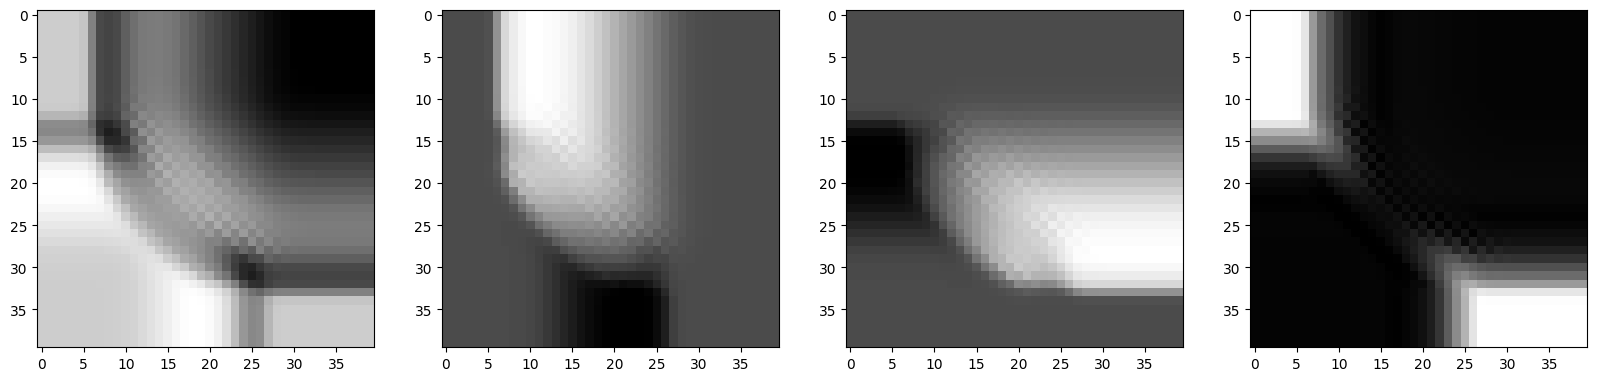

In [ ]:
plot(t1)
plot(t2)
plot(t3)

В качестве сравнения для второго порядка зададим сетку размером 320х320 и отобразим изображения

In [ ]:
alpha = 0.05
n = 0.125
M = 0.125

Nx, Ny = 40, 40
Nt = 40
T = 0.1

rho_0 = [1,1,1,10]
esp_0 = [10,1,1,10]
u_0 = [0,0,0,0]
v_0 = [0,0,0,0]

t1, t2, t3 = 3, 15, 25

gamma = 28/27
rho, u, v, eps = solve(orderXY = 2, orderT = 2, Nx = Nx, Ny = Ny, Nt = Nt, T = T, M = M, gamma = gamma,
                       alpha = alpha, n = n,
                       rho_0 = rho_0,
                       eps_0 = esp_0,
                       u_0 = u_0,
                       v_0 = v_0)

100%|██████████| 78/78 [00:21<00:00,  3.67it/s]


t = 0.0075000000000000015


<Figure size 640x480 with 0 Axes>

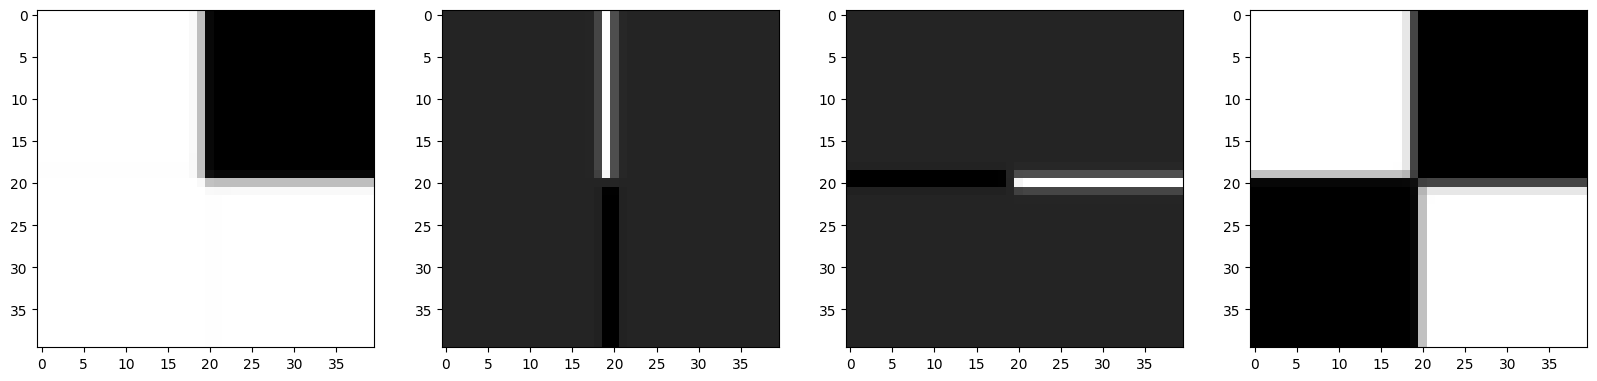

t = 0.0375


<Figure size 640x480 with 0 Axes>

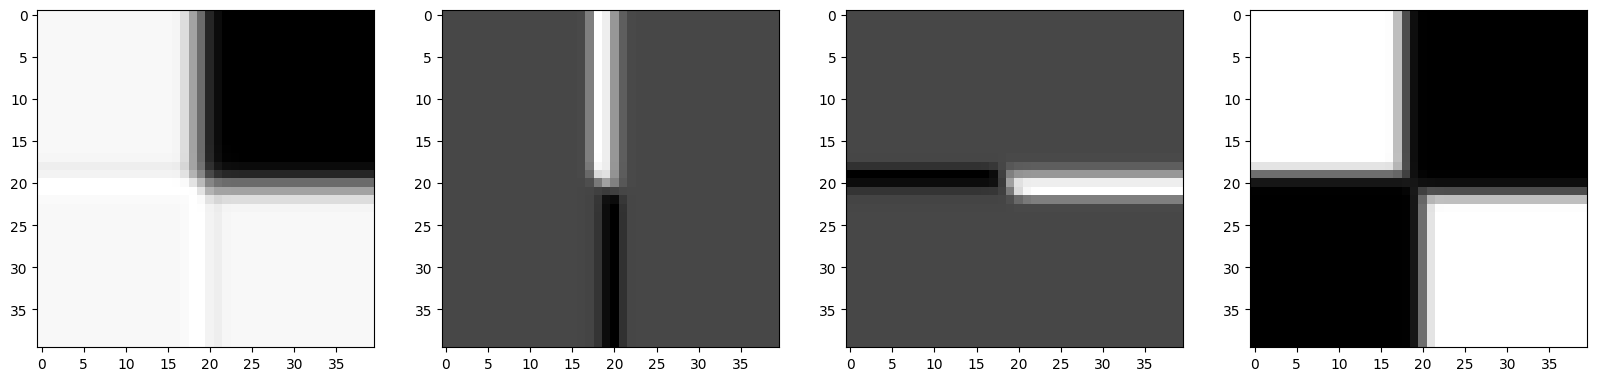

t = 0.0625


<Figure size 640x480 with 0 Axes>

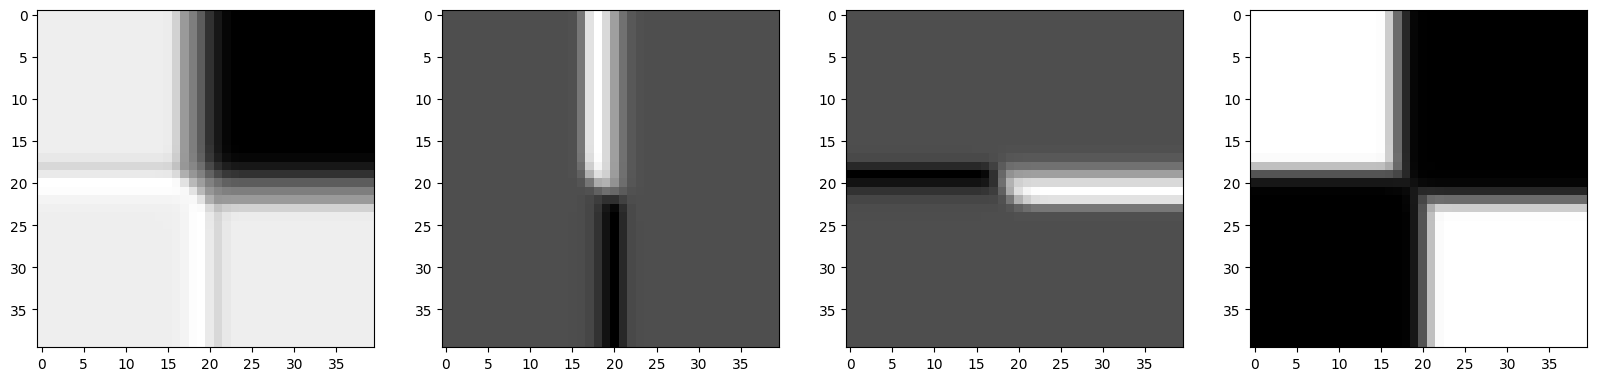

In [ ]:
plot(t1)
plot(t2)
plot(t3)

In [ ]:
def subdiv(lim_val):
    nx, ny, nt, tmax = 20, 20, 10, T / 2
    print('Size:', nx, 'x', ny, 'x', nt)
    r1, u1, v1, e1 = rho, u, v, eps = solve(orderXY = 1, orderT = 1, Nx = nx, Ny = ny, Nt = nt, T = tmax, M = M, gamma = gamma,
                       alpha = alpha, n = n,
                       rho_0 = rho_0,
                       eps_0 = esp_0,
                       u_0 = u_0,
                       v_0 = v_0)
    while True:
        nx, ny, nt = 2 * nx, 2 * ny, 2 * nt
        print('Size:', nx, 'x', ny, 'x', nt)
        r2, u2, v2, e2 =rho, u, v, eps = solve(orderXY = 1, orderT = 1, Nx = nx, Ny = ny, Nt = nt, T = tmax, M = M, gamma = gamma,
                       alpha = alpha, n = n,
                       rho_0 = rho_0,
                       eps_0 = esp_0,
                       u_0 = u_0,
                       v_0 = v_0)
        diffR = np.abs(r1 - r2[::2,::2,::2]).mean()
        diffU = np.abs(u1 - u2[::2,::2,::2]).mean()
        diffV = np.abs(v1 - v2[::2,::2,::2]).mean()
        diffE = np.abs(e1 - e2[::2,::2,::2]).mean()
        diff = diffR + diffU + diffV + diffE

        print('d rho:', diffR)
        print('d u:', diffU)
        print('d v:', diffV)
        print('d eps:', diffE)
        print('Sum d:', diff)

        if diff < lim_val:
            print('Done!')
            return r1, u1, v1, e1, r2, u2, v2, e2

        r1, u1, v1, e1 = r2, u2, v2, e2

In [ ]:
r1, u1, v1, e1, r2, u2, v2, e2 = subdiv(0.3)

Size: 20 x 20 x 10


100%|██████████| 9/9 [00:00<00:00, 23.61it/s]


Size: 40 x 40 x 20


100%|██████████| 19/19 [00:02<00:00,  8.42it/s]


d rho: 0.12481225097058038
d u: 0.017552927284001256
d v: 0.017552927284001256
d eps: 0.29507319750304967
Sum d: 0.4549913030416326
Size: 80 x 80 x 40


100%|██████████| 39/39 [00:15<00:00,  2.49it/s]


d rho: 0.10174769176153328
d u: 0.013047388015941198
d v: 0.013047388015941198
d eps: 0.1908285753053463
Sum d: 0.318671043098762
Size: 160 x 160 x 80


100%|██████████| 79/79 [02:04<00:00,  1.58s/it]

d rho: 0.08874694073585349
d u: 0.009048410277909378
d v: 0.009048410277909378
d eps: 0.12521398935483907
Sum d: 0.23205775064651132
Done!


t = 0.52


<Figure size 640x480 with 0 Axes>

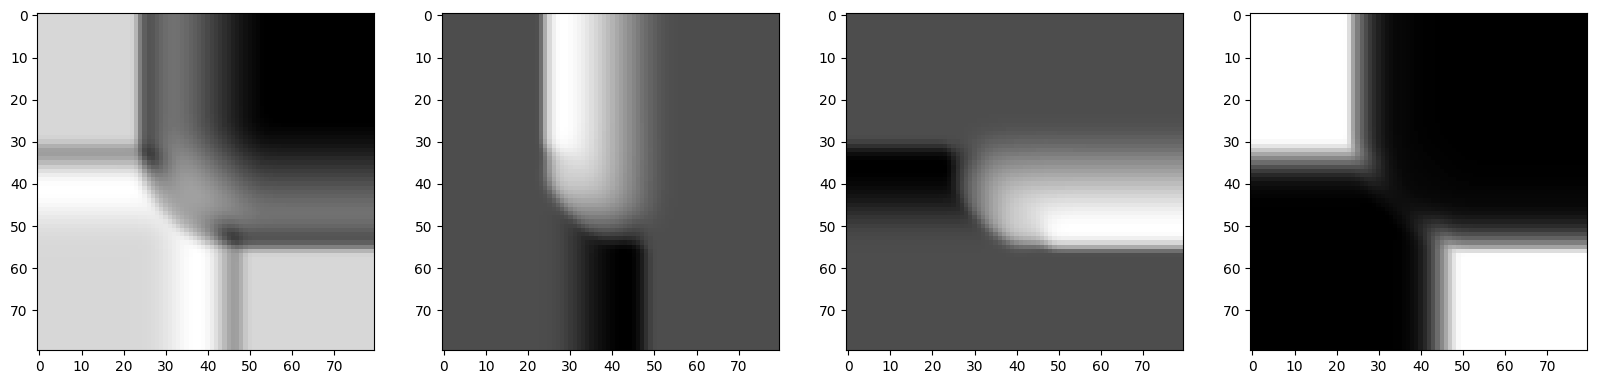

In [ ]:
rho, u, v, eps = r1, u1, v1, e1
plot(rho.shape[0] - 1)

t = 1.0533333333333335


<Figure size 640x480 with 0 Axes>

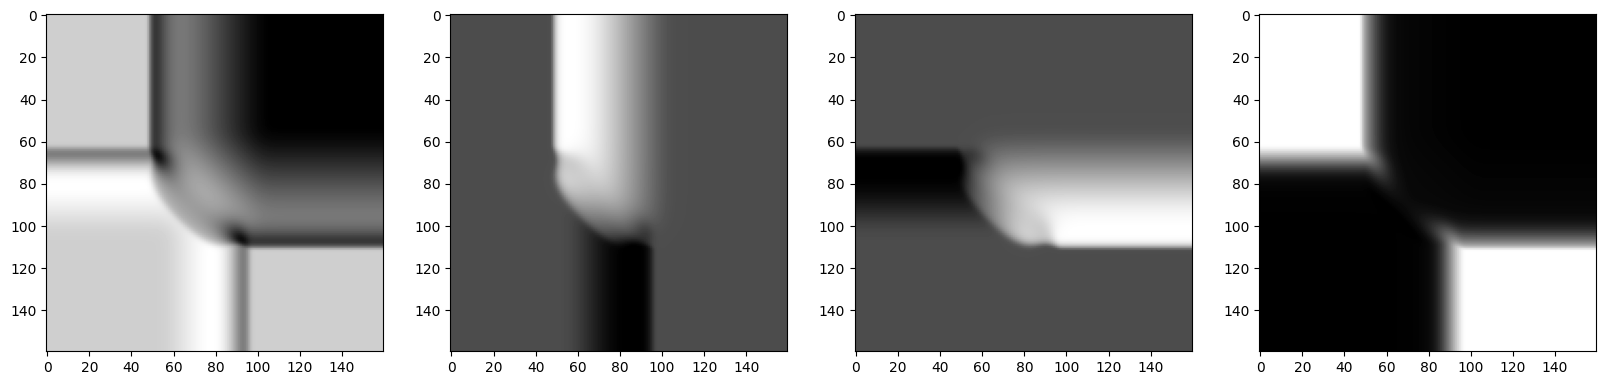

In [ ]:
rho, u, v, eps = r2, u2, v2, e2
plot(rho.shape[0] - 1)